In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda')

In [15]:
transform = transforms.Compose(
    [transforms.Resize(32),  # Resizing to 32x32
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [22:01<00:00, 129014.29it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
def position_embedding_layer(num_patches, embedding_dimension, batch_size):
    result = torch.ones(num_patches + 1, embedding_dimension)  # Add 1 for the class token
    result = result.to("cuda")
    for i in range(num_patches + 1):  # Add 1 for the class token
        for j in range(embedding_dimension):
            if j % 2 == 0:
                result[i][j] = (np.sin(i / (10000 ** (j / embedding_dimension))))
            else:
                result[i][j] = np.cos(i / (10000 ** ((j - 1) / embedding_dimension)))
    result = result.unsqueeze(0).repeat(batch_size, 1, 1)
    return result

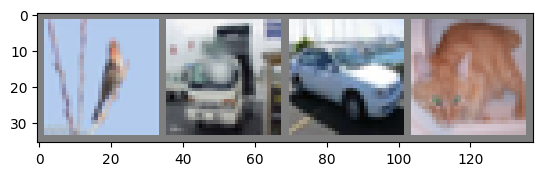

bird  truck car   cat  


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [18]:
class ConditionalPositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_size, num_features):
        super(ConditionalPositionalEncoding, self).__init__()
        self.num_patches = num_patches
        self.embed_size = embed_size
        self.num_features = num_features
        self.fc = nn.Linear(num_features, embed_size).to(device)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_size)).to(device)

    def forward(self, features):
        features = features.to(device)
        cond_embedding = self.fc(features)
        pos_embedding = self.pos_embedding.expand(features.size(0), -1, -1)
        combined_embedding = torch.cat([pos_embedding, cond_embedding.unsqueeze(1)], dim=1)
        return combined_embedding

def patchify(images, num_of_patches):
    batch_size, channels, height, width = images.shape

    assert height == width, "Patchify method is implemented for square images only"

    height_per_patch = height // num_of_patches
    width_per_patch = width // num_of_patches

    patches = torch.zeros(batch_size, num_of_patches ** 2, channels, height_per_patch, width_per_patch)
    patches = patches.to(device)

    for idx, image in enumerate(images):
        for i in range(num_of_patches):
            for j in range(num_of_patches):
                patch = image[
                    :,
                    i * height_per_patch: (i + 1) * height_per_patch,
                    j * width_per_patch: (j + 1) * width_per_patch,
                ]
                patches[idx, i * num_of_patches + j] = patch

    return patches

class Projection_Layer(nn.Module):
    def __init__(self, num_patches, patch_size, in_channels, embed_size):
        super(Projection_Layer, self).__init__()
        self.num_patches = num_patches
        self.layer_norm_1 = nn.LayerNorm(patch_size * patch_size * in_channels).to(device)
        self.embed_layer = nn.Linear(patch_size * patch_size * in_channels, embed_size).to(device)
        self.layer_norm_2 = nn.LayerNorm(embed_size).to(device)

    def forward(self, x):
        x = x.to(device)
        b, _, c, _, _ = x.shape
        x = x.permute(0, 1, 3, 4, 2)
        x = x.contiguous()
        x = x.view(b, self.num_patches, -1)
        x = self.layer_norm_1(x)
        x = self.embed_layer(x)
        x = self.layer_norm_2(x)

        return x
class Transformer_Block(nn.Module):
    def __init__(self, num_heads,embed_size,hidden_dim,dropout):
        super(Transformer_Block, self).__init__()

        self.norm = nn.LayerNorm(embed_size).to(device)
        self.attn = Attention(num_heads, embed_size)
        self.MLP = nn.Sequential(
            nn.LayerNorm(embed_size).to(device),
            nn.Linear(embed_size, hidden_dim).to(device),
            nn.GELU().to(device),
            nn.Linear(hidden_dim, embed_size).to(device),
            nn.Dropout(dropout).to(device)
        ).to(device)
    def forward(self,x):
        x = x.to(device)
        x = self.norm(x)
        x = self.attn(x) + x
        x = self.MLP(x) + x

        return x

class Attention(nn.Module):
    def __init__(self, num_heads, embed_size):
        super(Attention, self).__init__()

        eff_embed_size = embed_size // num_heads
        self.num_heads = num_heads
        self.Q_matrix = nn.Linear(eff_embed_size, eff_embed_size).to(device)
        self.K_matrix = nn.Linear(eff_embed_size, eff_embed_size).to(device)
        self.V_matrix = nn.Linear(eff_embed_size, eff_embed_size).to(device)
        self.temperature = eff_embed_size ** 0.5

    def forward(self, x):
        x = x.to(device)
        bs, n_1, embed_dim = x.shape
        x = x.view(bs, self.num_heads, n_1, embed_dim // self.num_heads)
        q = self.Q_matrix(x)
        k = self.K_matrix(x)
        v = self.V_matrix(x)

        attention = nn.Softmax(dim=-1).to(device)(torch.matmul(q, k.transpose(-1, -2))) / self.temperature
        x = torch.matmul(attention, v)
        x = x.view(bs, n_1, embed_dim)
        return x


class Vision_Transformer(nn.Module):
    def __init__(self, image_size=32, in_channels=3, patch_size=8, embed_size=192, hidden_dim=768, num_heads=8,
                 num_layers=12, dropout=0.01, num_of_patches=4):
        super(Vision_Transformer, self).__init__()

        self.num_patches = (image_size // patch_size) ** 2
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.in_channels = in_channels

        self.projection_layer = Projection_Layer(self.num_patches, patch_size, in_channels, embed_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size)).to(device)
        self.pos_emb = position_embedding_layer(self.num_patches, embed_size, 1)

        self.layers = nn.Sequential(*[Transformer_Block(num_heads, embed_size, hidden_dim, dropout)
                                      for _ in range(num_layers)]).to(device)

        self.clf_head = nn.Linear(embed_size, 10).to(device)

    def forward(self, x):
        x = x.to(device)
        bs, _, _, _ = x.shape
        x = patchify(x, int(self.num_patches ** 0.5))
        x = self.projection_layer(x)

        cls_token = self.cls_token.expand(bs, -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_emb

        for layer in self.layers:
            x = layer(x)

        x = self.clf_head(x[:, 0, :])
        return x



In [19]:
net = Vision_Transformer()
net = net.to(device)


In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

2005it [01:15, 26.06it/s]

[1,  2000] loss: 2.173


4005it [02:30, 28.10it/s]

[1,  4000] loss: 2.075


6003it [03:46, 25.55it/s]

[1,  6000] loss: 2.051


8005it [05:01, 29.13it/s]

[1,  8000] loss: 2.035


10005it [06:16, 25.91it/s]

[1, 10000] loss: 2.014


12002it [07:31, 25.62it/s]

[1, 12000] loss: 2.005


12500it [07:50, 26.57it/s]
2005it [01:15, 28.47it/s]

[2,  2000] loss: 1.977


4002it [02:29, 25.17it/s]

[2,  4000] loss: 1.973


6005it [03:43, 28.06it/s]

[2,  6000] loss: 1.969


8006it [05:00, 28.56it/s]

[2,  8000] loss: 1.952


10004it [06:14, 27.21it/s]

[2, 10000] loss: 1.931


12005it [07:28, 29.02it/s]

[2, 12000] loss: 1.948


12500it [07:47, 26.73it/s]
2005it [01:15, 29.18it/s]

[3,  2000] loss: 1.909


4002it [02:30, 26.53it/s]

[3,  4000] loss: 1.900


6003it [03:45, 29.28it/s]

[3,  6000] loss: 1.883


8004it [05:01, 28.94it/s]

[3,  8000] loss: 1.865


10003it [06:15, 26.86it/s]

[3, 10000] loss: 1.842


12004it [07:31, 26.37it/s]

[3, 12000] loss: 1.815


12500it [07:50, 26.59it/s]
2004it [01:13, 27.79it/s]

[4,  2000] loss: 1.774


4004it [02:27, 29.16it/s]

[4,  4000] loss: 1.758


6005it [03:42, 26.42it/s]

[4,  6000] loss: 1.767


8004it [04:56, 24.76it/s]

[4,  8000] loss: 1.762


10003it [06:10, 26.34it/s]

[4, 10000] loss: 1.725


12005it [07:26, 25.93it/s]

[4, 12000] loss: 1.713


12500it [07:45, 26.86it/s]
2004it [01:14, 26.26it/s]

[5,  2000] loss: 1.673


4003it [02:27, 28.88it/s]

[5,  4000] loss: 1.653


6003it [03:40, 27.17it/s]

[5,  6000] loss: 1.664


8004it [04:54, 26.44it/s]

[5,  8000] loss: 1.630


10003it [06:06, 28.96it/s]

[5, 10000] loss: 1.628


12005it [07:18, 28.76it/s]

[5, 12000] loss: 1.632


12500it [07:37, 27.34it/s]
2005it [01:12, 27.85it/s]

[6,  2000] loss: 1.561


4004it [02:27, 27.20it/s]

[6,  4000] loss: 1.581


6003it [03:43, 27.14it/s]

[6,  6000] loss: 1.543


8004it [04:59, 27.24it/s]

[6,  8000] loss: 1.537


10004it [06:13, 26.83it/s]

[6, 10000] loss: 1.567


12003it [07:29, 23.90it/s]

[6, 12000] loss: 1.557


12500it [07:48, 26.68it/s]
2004it [01:14, 27.50it/s]

[7,  2000] loss: 1.472


4004it [02:29, 25.18it/s]

[7,  4000] loss: 1.496


6004it [03:44, 26.14it/s]

[7,  6000] loss: 1.469


8003it [04:59, 26.50it/s]

[7,  8000] loss: 1.507


10004it [06:14, 27.38it/s]

[7, 10000] loss: 1.461


12005it [07:26, 30.47it/s]

[7, 12000] loss: 1.481


12500it [07:43, 26.95it/s]
2005it [01:11, 29.88it/s]

[8,  2000] loss: 1.401


4002it [02:20, 25.54it/s]

[8,  4000] loss: 1.390


6005it [03:30, 29.72it/s]

[8,  6000] loss: 1.413


8003it [04:42, 25.56it/s]

[8,  8000] loss: 1.422


10006it [05:57, 25.77it/s]

[8, 10000] loss: 1.412


12006it [07:04, 30.14it/s]

[8, 12000] loss: 1.418


12500it [07:20, 28.35it/s]
2003it [01:05, 28.99it/s]

[9,  2000] loss: 1.321


4004it [02:12, 32.12it/s]

[9,  4000] loss: 1.310


6004it [03:21, 28.79it/s]

[9,  6000] loss: 1.357


8003it [04:27, 29.54it/s]

[9,  8000] loss: 1.354


10004it [05:32, 32.03it/s]

[9, 10000] loss: 1.340


12003it [06:37, 31.96it/s]

[9, 12000] loss: 1.349


12500it [06:54, 30.14it/s]
2003it [01:05, 31.69it/s]

[10,  2000] loss: 1.223


4003it [02:10, 30.96it/s]

[10,  4000] loss: 1.262


6002it [03:16, 31.02it/s]

[10,  6000] loss: 1.277


8003it [04:20, 31.40it/s]

[10,  8000] loss: 1.271


10004it [05:25, 31.00it/s]

[10, 10000] loss: 1.266


12004it [06:30, 31.71it/s]

[10, 12000] loss: 1.283


12500it [06:47, 30.67it/s]
2005it [01:04, 30.70it/s]

[11,  2000] loss: 1.157


4006it [02:10, 29.47it/s]

[11,  4000] loss: 1.189


6006it [03:17, 30.46it/s]

[11,  6000] loss: 1.184


8006it [04:24, 30.47it/s]

[11,  8000] loss: 1.197


10002it [05:32, 25.62it/s]

[11, 10000] loss: 1.212


12006it [06:39, 30.78it/s]

[11, 12000] loss: 1.216


12500it [06:56, 30.02it/s]
2004it [01:06, 31.88it/s]

[12,  2000] loss: 1.065


4006it [02:13, 31.59it/s]

[12,  4000] loss: 1.134


6004it [03:19, 27.94it/s]

[12,  6000] loss: 1.137


8004it [04:27, 31.09it/s]

[12,  8000] loss: 1.116


10004it [05:34, 29.00it/s]

[12, 10000] loss: 1.141


12004it [06:40, 28.56it/s]

[12, 12000] loss: 1.141


12500it [06:57, 29.92it/s]
2006it [01:06, 31.94it/s]

[13,  2000] loss: 0.981


4004it [02:12, 28.70it/s]

[13,  4000] loss: 1.047


6004it [03:19, 31.39it/s]

[13,  6000] loss: 1.052


8003it [04:24, 28.89it/s]

[13,  8000] loss: 1.084


10005it [05:31, 30.23it/s]

[13, 10000] loss: 1.081


12005it [06:38, 29.12it/s]

[13, 12000] loss: 1.101


12500it [06:55, 30.11it/s]
2006it [01:08, 31.72it/s]

[14,  2000] loss: 0.947


4003it [02:15, 30.46it/s]

[14,  4000] loss: 0.980


6003it [03:22, 31.12it/s]

[14,  6000] loss: 0.996


8003it [04:29, 31.68it/s]

[14,  8000] loss: 0.999


10006it [05:35, 31.36it/s]

[14, 10000] loss: 1.019


12006it [06:41, 31.01it/s]

[14, 12000] loss: 1.040


12500it [06:57, 29.93it/s]
2003it [01:05, 29.87it/s]

[15,  2000] loss: 0.863


4006it [02:11, 32.65it/s]

[15,  4000] loss: 0.905


6005it [03:16, 31.92it/s]

[15,  6000] loss: 0.952


8004it [04:23, 31.34it/s]

[15,  8000] loss: 0.972


10005it [05:30, 24.52it/s]

[15, 10000] loss: 0.984


12002it [06:37, 27.91it/s]

[15, 12000] loss: 1.000


12500it [06:54, 30.14it/s]
2006it [01:10, 29.55it/s]

[16,  2000] loss: 0.806


4003it [02:23, 25.95it/s]

[16,  4000] loss: 0.881


6003it [03:32, 28.76it/s]

[16,  6000] loss: 0.892


8005it [04:42, 28.81it/s]

[16,  8000] loss: 0.921


10004it [05:52, 30.51it/s]

[16, 10000] loss: 0.924


12003it [07:01, 26.52it/s]

[16, 12000] loss: 0.940


12500it [07:19, 28.47it/s]
2006it [01:09, 29.96it/s]

[17,  2000] loss: 0.737


4004it [02:19, 25.92it/s]

[17,  4000] loss: 0.829


6005it [03:29, 29.47it/s]

[17,  6000] loss: 0.848


8004it [04:39, 30.29it/s]

[17,  8000] loss: 0.872


10003it [05:50, 28.28it/s]

[17, 10000] loss: 0.875


12003it [07:02, 29.01it/s]

[17, 12000] loss: 0.888


12500it [07:20, 28.37it/s]
2005it [01:09, 26.06it/s]

[18,  2000] loss: 0.723


4003it [02:19, 29.93it/s]

[18,  4000] loss: 0.795


6005it [03:28, 29.00it/s]

[18,  6000] loss: 0.817


8003it [04:38, 27.85it/s]

[18,  8000] loss: 0.823


10004it [05:48, 28.48it/s]

[18, 10000] loss: 0.844


12003it [06:58, 28.16it/s]

[18, 12000] loss: 0.840


12500it [07:15, 28.69it/s]
2002it [01:12, 30.10it/s]

[19,  2000] loss: 0.681


4004it [02:22, 29.83it/s]

[19,  4000] loss: 0.716


6005it [03:31, 30.26it/s]

[19,  6000] loss: 0.748


8004it [04:40, 30.26it/s]

[19,  8000] loss: 0.776


10004it [05:50, 30.23it/s]

[19, 10000] loss: 0.825


12004it [06:59, 28.81it/s]

[19, 12000] loss: 0.850


12500it [07:16, 28.63it/s]
2003it [01:09, 26.92it/s]

[20,  2000] loss: 0.625


4004it [02:19, 27.83it/s]

[20,  4000] loss: 0.690


6004it [03:29, 30.75it/s]

[20,  6000] loss: 0.718


8003it [04:41, 29.86it/s]

[20,  8000] loss: 0.747


10004it [05:57, 28.50it/s]

[20, 10000] loss: 0.774


12002it [07:10, 25.03it/s]

[20, 12000] loss: 0.783


12500it [07:29, 27.79it/s]

Finished Training


In [22]:
net.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss / len(testloader):.3f}')
print(f'Test Accuracy: {(100 * correct / total):.2f}%')

net.train()

2500it [00:40, 61.74it/s]

Test Loss: 1.477
Test Accuracy: 54.04%


Vision_Transformer(
  (projection_layer): Projection_Layer(
    (layer_norm_1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (embed_layer): Linear(in_features=192, out_features=192, bias=True)
    (layer_norm_2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): Transformer_Block(
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (Q_matrix): Linear(in_features=24, out_features=24, bias=True)
        (K_matrix): Linear(in_features=24, out_features=24, bias=True)
        (V_matrix): Linear(in_features=24, out_features=24, bias=True)
      )
      (MLP): Sequential(
        (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=192, out_features=768, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=768, out_features=192, bias=True)
        (4): Dropout(p=0.01, inplace=False)
      )
    )
    (1): Transformer_Block(
  